# 0.0 IMPORTS

In [1]:
import re
import warnings
import sweetviz
import IPython
import pickle
import itertools

import pandas            as pd
import numpy             as np
import lightgbm          as lgb
import xgboost           as xgb
import seaborn           as sns

from category_encoders       import TargetEncoder
from sklearn.preprocessing   import OneHotEncoder
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from scipy                   import stats
from unidecode               import unidecode
from catboost                import CatBoostClassifier
from skopt                   import gp_minimize
from sklearn.model_selection import cross_val_score, KFold
from imblearn                import over_sampling, under_sampling
from sklearn                 import svm
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neural_network  import MLPClassifier

from sklearn                 import model_selection   as ms
from sklearn                 import metrics           as m
from matplotlib              import pyplot            as plt
from imblearn                import combine           as co
from sklearn                 import manifold          as mn
from sklearn                 import cluster           as c
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 AUX FUNCTIONS

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

def ml_error( model_name, ytest, yhat ):
    f1 = m.f1_score( ytest, yhat )

    return pd.DataFrame( {'Model name': model_name,
                          'F1': f1 }, index=[0] )

## 0.2 READ DATASETS

# 2.0 DATA FILTERING

In [3]:
df = pd.read_csv('datasets/train.csv')

# 1.0 DATA DESCRIPTION

In [4]:
df2 = df.copy()

for i in range(len( df2)):
    if df2['num_contas_bancarias'][i] == 0:
        df2['num_contas_bancarias'][i] = 1

df2['num_contas_bancarias'] = df2['num_contas_bancarias'].apply( lambda x: int(str(x)[:2]) if x>50 else x )

df2['idade'] = df2['idade'].apply( lambda x: int(str(x)[:2]) if x>100 else x )
df2['idade'] = df2['idade'].apply( lambda x: 18 if x < 18 else x )

df2['taxa_juros'] = df2['taxa_juros'].apply( lambda x: int(str(x)[:2]) if x>100 else x )
df2['taxa_juros'] = df2['taxa_juros'].apply( lambda x: x/100 )

mediana_cartao = df2['num_cartoes_credito'].median()
df2['num_cartoes_credito'] = df2['num_cartoes_credito'].apply( lambda x: mediana_cartao if x>100 else x )

df2['num_emprestimos'] = df2['num_emprestimos'].apply( lambda x: int(str(x)[:2]) if x>100 else x )

mediana_pg = df2['num_pgtos_atrasados'].median()
df2['num_pgtos_atrasados'] = df2['num_pgtos_atrasados'].apply( lambda x: mediana_pg if x>100 else x )

df2['num_consultas_credito'] = df2['num_consultas_credito'].apply( lambda x: int(str(x)[:2]) if x>100 else x )

# 3.0 FEATURE ENGINEERING

In [5]:
df3 = df2.copy()

df3['porcentagem_investido'] = df3.apply( lambda x: x.valor_em_investimentos / x.renda_anual, axis=1 )

df3['renda_anual'] = df3['renda_anual'].apply( lambda x: x/12 )

df3['faixa_num_emprestimos'] = df3['num_emprestimos'].apply( lambda x: '0' if x <= 0 else 
                                                                       '1 - 3' if x >= 1 and x <= 3 else
                                                                       '4 - 6' if x >= 4 and x <= 6 else
                                                                       '6 - 9' if x >= 6 and x <= 9 else
                                                                       '10 +' if x > 10 else x)

df3['porcentagem_divida'] = df3.apply( lambda x: x['renda_anual'] / x['divida_atual'], axis=1 )
df3['atraso_max_34'] = df3['num_pgtos_atrasados'].apply( lambda x: 1 if x <=34 else 0 )
df3['nenhum_dia_de_atraso'] = df3['dias_atraso_dt_venc'].apply( lambda x: 1 if x <=0 else 0 )

# 4.0 EDA

In [6]:
df4 = df3.copy()

# 5.0 DATA PREPARATION

In [7]:
df5 = df3.copy()

## 5.1 Rescaling

In [8]:
# Min Max Scaler
mms = MinMaxScaler()
rs = RobustScaler()

df5['idade'] = rs.fit_transform( df5[['idade']].values )
pickle.dump( rs, open( 'encoders/idade_scaler', 'wb') )

df5['porcentagem_investido'] = rs.fit_transform( df5[['porcentagem_investido']].values )
pickle.dump( rs, open( 'encoders/porcentagem_investido_scaler', 'wb') )

df5['num_contas_bancarias'] = rs.fit_transform( df5[['num_contas_bancarias']].values )
pickle.dump( rs, open( 'encoders/num_contas_bancarias_scaler', 'wb') )

df5['taxa_juros'] = rs.fit_transform( df5[['taxa_juros']].values )
pickle.dump( rs, open( 'encoders/taxa_juros_scaler', 'wb') )

df5['num_cartoes_credito'] = rs.fit_transform( df5[['num_cartoes_credito']].values )
pickle.dump( rs, open( 'encoders/num_cartoes_credito_scaler', 'wb') )

df5['taxa_utilizacao_credito'] = rs.fit_transform( df5[['taxa_utilizacao_credito']].values )
pickle.dump( rs, open( 'encoders/taxa_utilizacao_credito_scaler', 'wb') )

df5['num_emprestimos'] = rs.fit_transform( df5[['num_emprestimos']].values )
pickle.dump( rs, open( 'encoders/num_emprestimos_scaler', 'wb') )

df5['num_pgtos_atrasados'] = rs.fit_transform( df5[['num_pgtos_atrasados']].values )
pickle.dump( rs, open( 'encoders/num_pgtos_atrasados_scaler', 'wb') )

df5['dias_atraso_dt_venc'] = rs.fit_transform( df5[['dias_atraso_dt_venc']].values )
pickle.dump( rs, open( 'encoders/dias_atraso_dt_venc_scaler', 'wb') )

df5['num_consultas_credito'] = rs.fit_transform( df5[['num_consultas_credito']].values )
pickle.dump( rs, open( 'encoders/num_consultas_credito_scaler', 'wb') )

# Robust Scaler

df5['saldo_atual'] = rs.fit_transform( df5[['saldo_atual']].values )
pickle.dump( rs, open( 'encoders/saldo_atual_scaler', 'wb') )

df5['divida_atual'] = rs.fit_transform( df5[['divida_atual']].values )
pickle.dump( rs, open( 'encoders/divida_atual_scaler', 'wb') )

df5['renda_anual'] = rs.fit_transform( df5[['renda_anual']].values )
pickle.dump( rs, open( 'encoders/renda_anual_scaler', 'wb') )

df5['valor_em_investimentos'] = rs.fit_transform( df5[['valor_em_investimentos']].values )
pickle.dump( rs, open( 'encoders/valor_em_investimentos_scaler', 'wb') )

df5['porcentagem_divida'] = rs.fit_transform( df5[['porcentagem_divida']].values )
pickle.dump( rs, open( 'encoders/porcentagem_divida_scaler', 'wb') )

## 5.2 Encoding

In [9]:
# limite adicional
df5['limite_adicional'] = df5['limite_adicional'].apply( lambda x: 0 if x == 'Negar' else 1 )

# target encoder
te = TargetEncoder()

df5['investe_exterior'] = te.fit_transform( df5['investe_exterior'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/investe_exterior_encoding', 'wb' ) )

df5['pessoa_polit_exp'] = te.fit_transform( df5['pessoa_polit_exp'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/pessoa_polit_exp_encoding', 'wb' ) )

df5['faixa_num_emprestimos'] = te.fit_transform( df5['faixa_num_emprestimos'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/faixa_num_emprestimos_encoding', 'wb' ) )

# Resampling Data

In [10]:
df_features = df5.drop( columns='limite_adicional')
df_target = df5['limite_adicional'].copy()

In [11]:
# define
smt = co.SMOTETomek()

# apply
features_smt, target_smt = smt.fit_resample( df_features, df_target )

# 6.0 FEATURE SELECTION

In [12]:
# model
forest = ExtraTreesClassifier( n_jobs=-1 )

# training
X = df5.drop( columns=['limite_adicional','investe_exterior','pessoa_polit_exp'])
Y = df5['limite_adicional'].values

x_train_fselection, x_val, y_train_fselection, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesClassifier(n_jobs=-1)

Feature Ranking:

                   feature  importance
0      dias_atraso_dt_venc    0.110802
0               taxa_juros    0.098630
0      num_cartoes_credito    0.091136
0      num_pgtos_atrasados    0.090141
0     num_contas_bancarias    0.065627
0             divida_atual    0.058464
0    num_consultas_credito    0.055096
0              saldo_atual    0.048885
0                    idade    0.047233
0               id_cliente    0.043921
0  taxa_utilizacao_credito    0.043369
0              renda_anual    0.043341
0       porcentagem_divida    0.041335
0   valor_em_investimentos    0.040524
0    porcentagem_investido    0.039793
0    faixa_num_emprestimos    0.039547
0          num_emprestimos    0.031935
0     nenhum_dia_de_atraso    0.010191
0            atraso_max_34    0.000030


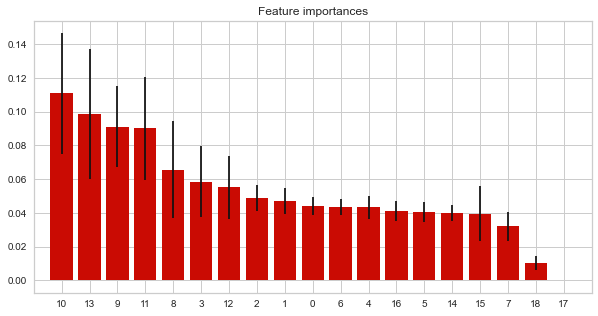

In [13]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

# 7.0 MACHINE LEARNING

In [35]:
X = features_smt.drop( columns = ['id_cliente'] )
Y = target_smt.copy()

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1 LightGBM

In [36]:
# model
model_lgb = lgb.LGBMClassifier( n_estimators=1500, max_depth=13, learning_rate=0.006152297529980611, num_leaves=128, 
min_child_samples=1, subsample=1, colsample_bytree= 0.6141176359008, n_jobs=-1, random_state=42, subsample_freq=1 ).fit( X_train, y_train )
# model_lgb = lgb.LGBMClassifier( n_jobs=-1 ).fit( X_train, y_train )
pickle.dump( model_lgb, open( 'model/model_lgb.pkl', 'wb' ) )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM',  y_val, yhat_lgb )
model_lgb_results

,Model name,F1
0,LightGBM,0.938803


### 7.1.1 Cross Validation

In [37]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_lgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.2 XGBoost

In [38]:
# model
# model_xgb = xgb.XGBClassifier( n_estimators=1061, gamma=7, reg_alpha=1, min_child_weight=10,
# colsample_bytree=0.8808060214289094, n_jobs=-1 ).fit( X_train, y_train )
model_xgb = xgb.XGBClassifier( n_jobs=-1 ).fit( X_train, y_train )
#[1061, 7, 1, 10, 0.8808060214289094]

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost',  y_val, yhat_xgb )
model_xgb_results

,Model name,F1
0,XGBoost,0.93159


### 7.2.1 Cross Validation

In [39]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_xgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.3 CatBoost

In [40]:
# model
model_cb = CatBoostClassifier( depth=10, learning_rate=0.0981874662401154, iterations=189, verbose=False ).fit( X_train, y_train )
# model_cb = CatBoostClassifier( verbose=False ).fit( X_train, y_train )

# prediction
yhat_cb = model_cb.predict( X_val )

# performance
model_cb_results = ml_error( 'CatBoost',  y_val, yhat_cb)
model_cb_results

,Model name,F1
0,CatBoost,0.940393


### 7.3.1 Cross Validation

## 7.4 Random Forest Classifier

In [41]:
# model
# model_rf = RandomForestClassifier( n_estimators=, max_depth=, min_samples_split=, min_samples_leaf=,
# max_features= ).fit( X_train, y_train )
model_rf = RandomForestClassifier().fit( X_train, y_train )

# prediction
yhat_rf = model_rf.predict( X_val )

# performance
model_rf_results = ml_error( 'CatBoost',  y_val, yhat_rf)
model_rf_results

,Model name,F1
0,CatBoost,0.93715


## 7.5 Extra Trees Classifier

In [42]:
# model
model_et = ExtraTreesClassifier( n_estimators=425, max_depth=50, min_samples_split=2, min_samples_leaf=1,
max_features=11 ).fit( X_train, y_train )
pickle.dump( model_et, open( 'model/model_et.pkl', 'wb' ) )

# prediction
yhat_et = model_et.predict( X_val )

# performance
model_et_results = ml_error( 'CatBoost',  y_val, yhat_et)
model_et_results

,Model name,F1
0,CatBoost,0.947026


## 7.6 KNN

In [43]:
# model
# model_knn = KNeighborsClassifier( leaf_size=47, n_neighbors=1, p=1 ).fit( X_train, y_train )
model_knn = KNeighborsClassifier().fit( X_train, y_train )
#[47, 1, 1]

# prediction
yhat_knn = model_knn.predict( X_val )

# performance
model_knn_results = ml_error( 'KNN',  y_val, yhat_knn)
model_knn_results

,Model name,F1
0,KNN,0.875786


# 7.7 Logistic Regression

In [44]:
# model
model_logistic = LogisticRegression().fit( X_train, y_train )

# prediction
yhat_logistic = model_logistic.predict( X_val )

# performance
model_logistic_results = ml_error( 'Logistic',  y_val, yhat_logistic)
model_logistic_results

,Model name,F1
0,Logistic,0.858056


## 7.8 Naive Bayes

In [45]:
# model
model_gaussian = GaussianNB().fit( X_train, y_train )

# prediction
yhat_gaussian = model_gaussian.predict( X_val )

# performance
model_gaussian_results = ml_error( 'Logistic',  y_val, yhat_gaussian )
model_gaussian_results

,Model name,F1
0,Logistic,0.815309


## 7.9 SVM

In [46]:
# model
model_svm = svm.SVC().fit( X_train, y_train )

# prediction
yhat_svm = model_svm.predict( X_val )

# performance
model_svm_results = ml_error( 'Logistic',  y_val, yhat_svm )
model_svm_results

,Model name,F1
0,Logistic,0.818002


# 7.10 Decision Tree

In [47]:
# model
# model_dt = DecisionTreeClassifier( max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features=12 ).fit( X_train, y_train )
model_dt = DecisionTreeClassifier().fit( X_train, y_train )
#[262, 10, 2, 2, 12]

# prediction
yhat_dt = model_dt.predict( X_val )

# performance
model_dt_results = ml_error( 'Decision Tree',  y_val, yhat_dt )
model_dt_results

,Model name,F1
0,Decision Tree,0.894929


# 7.11 MLP

In [48]:
# Criando a rede neural
rede_neural_credit = MLPClassifier(max_iter=1500, verbose=False, tol=0.000100,
                                   solver = 'adam', activation = 'relu',
                                   hidden_layer_sizes = (30,20)).fit(X_train, y_train)

# Fit vai fazer o ajuste dos pesos (treinamento)
yhat_mlp = rede_neural_credit.predict( X_val )

# Função que faz a contagem dos acertos e dos erros
model_mlp_results = ml_error( 'MLP',  y_val, yhat_mlp )
model_mlp_results

,Model name,F1
0,MLP,0.88018


## 7.12 Stacking Classifier

In [49]:
estimators_list = [ ('lgbm', model_lgb), ('xgboost', model_xgb), ('catboost', model_cb), ('random forest', model_rf ), ('extra trees', model_et), 
('decision tree', model_dt), ('knn', model_knn), ('logistic regression', model_logistic), ('gaussian', model_gaussian), ('svm', model_svm), ('rede neural', rede_neural_credit) ]

# Build stack model
stack_model = StackingClassifier( estimators = estimators_list, n_jobs=-1, verbose=True ).fit( X_train, y_train )
pickle.dump( stack_model, open( 'model/model_stack.pkl', 'wb' ) )

# prediction
yhat_stack = stack_model.predict( X_val )

# performance
stack_model_results = ml_error( 'Stacking', y_val, yhat_stack )
stack_model_results

KeyboardInterrupt: 

In [ ]:
stack_model = StackingClassifier( estimators = estimators_list, n_jobs=-1, verbose=True ).fit( X, Y )
pickle.dump( stack_model, open( 'model/model_stack_final.pkl', 'wb' ) )

### 7.7.1 Cross Validation

In [ ]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(stack_model, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

# 8.0 Bayesian Optimization

## 8.1 LGBM

In [ ]:
search_space = [(100, 1500), #name = 'n_estimators'), 
                (1, 20), #name = 'max_depth'), 
                (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
                (2, 128), #name = 'num_leaves'),
                (1, 100), #name = 'min_child_samples'),
                (0.05, 1.0), #name = 'subsample'),
                (0.15, 1.0) #name = 'colsample_bytree')]
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    num_leaves = params[3]
    min_child_samples = params[4]
    subsample = params[5]
    colsample_bytree = params[6]

    print(params, '\n')

    lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
    lgbm_model.fit( X_train, y_train )

    yhat_lgb = lgbm_model.predict( X_val )

    return -m.f1_score( y_val, yhat_lgb )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[1215, 4, 0.036256176345762295, 77, 45, 0.14497617002710278, 0.5403615581709872] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.3491
Function value obtained: -0.9245
Current minimum: -0.9245
Iteration No: 2 started. Evaluating function at random point.
[567, 4, 0.020034427927560734, 9, 72, 0.9416250735649628, 0.15066195096486218] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9956
Function value obtained: -0.9353
Current minimum: -0.9353
Iteration No: 3 started. Evaluating function at random point.
[1489, 13, 0.01672269700618368, 3, 3, 0.5485359272454697, 0.48988182595796725] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.5420
Function value obtained: -0.9302
Current minimum: -0.9353
Iteration No: 4 started. Evaluating function at random point.
[165, 20, 0.0029210748185657135, 13, 62, 0.41333889170380467, 0.9857462529357701] 

Iteration No: 4 ended. E

KeyboardInterrupt: 

In [ ]:
result.x

[1500, 1, 0.1, 2, 46, 1.0, 0.15]

## 8.2 XGBoost

In [ ]:
search_space = [(100, 1500), #n_estimators
                (1, 9), #gamma, 
                (1, 180),#reg_alpha
                (1, 10), #min_child_weight
                (0.15, 1.0) #colsample_bytree
]

def treinar_modelo( params ):
    n_estimators = params[0]
    gamma = params[1]
    reg_alpha = params[2]
    min_child_weight = params[3]
    colsample_bytree = params[4]

    print(params, '\n')

    xgb_model = xgb.XGBClassifier( n_estimators=n_estimators, gamma=gamma, reg_alpha=reg_alpha, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42)
    xgb_model.fit( X_train, y_train )

    yhat_xgb = xgb_model.predict( X_val )

    return -m.f1_score( y_val, yhat_xgb )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[1215, 2, 141, 6, 0.5289578399255526] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7090
Function value obtained: -0.8482
Current minimum: -0.8482
Iteration No: 2 started. Evaluating function at random point.
[240, 5, 61, 2, 0.703255202006525] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6387
Function value obtained: -0.8418
Current minimum: -0.8482
Iteration No: 3 started. Evaluating function at random point.
[179, 7, 169, 1, 0.9933798253975351] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4610
Function value obtained: -0.8158
Current minimum: -0.8482
Iteration No: 4 started. Evaluating function at random point.
[964, 6, 2, 1, 0.5960584612196308] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.4405
Function value obtained: -0.8471
Current minimum: -0.8482
Iteration No: 5 started. Evaluating function at random point.
[660,

In [ ]:
result.x

[1079, 8, 1, 3, 0.966308172562036]

## 8.3 CatBoost

In [ ]:
search_space = [(6, 10), #depth
                (0.01, 0.1), #learning rate
                (100, 200), #iterations
]

def treinar_modelo( params ):
    depth = params[0]
    learning_rate = params[1]
    iterations = params[2]

    print(params, '\n' )

    catboost_model = CatBoostClassifier( depth = depth, learning_rate=learning_rate, iterations=iterations, verbose=False )
    catboost_model.fit( X_train, y_train )

    yhat_catboost = catboost_model.predict( X_val )

    return -m.f1_score( y_val, yhat_catboost )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[9, 0.026509131087954746, 178] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.7777
Function value obtained: -0.9355
Current minimum: -0.9355
Iteration No: 2 started. Evaluating function at random point.
[8, 0.05012494775682322, 110] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5892
Function value obtained: -0.9341
Current minimum: -0.9355
Iteration No: 3 started. Evaluating function at random point.
[8, 0.04003377500251198, 114] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.4938
Function value obtained: -0.9362
Current minimum: -0.9362
Iteration No: 4 started. Evaluating function at random point.
[9, 0.015077042112439026, 172] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.1451
Function value obtained: -0.9316
Current minimum: -0.9362
Iteration No: 5 started. Evaluating function at random point.
[10, 0.01007008892569129, 1

KeyboardInterrupt: 

In [ ]:
result.x

[10, 0.08029086286368893, 200]

## 8.4 Random Forest Classifier

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_rf = RandomForestClassifier( n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, random_state=42)
    model_rf.fit( X_train, y_train )

    yhat_rf = model_rf.predict( X_val )

    return -m.f1_score( y_val, yhat_rf )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.7026
Function value obtained: -0.9128
Current minimum: -0.9128
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6700
Function value obtained: -0.9251
Current minimum: -0.9251
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2110
Function value obtained: -0.9243
Current minimum: -0.9251
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.7678
Function value obtained: -0.9239
Current minimum: -0.9251
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random po

In [ ]:
result.x

[435, 29, 2, 1, 1]

## 8.5 Extra Trees Classifier

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_et = ExtraTreesClassifier( n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=-1, random_state=42)
    model_et.fit( X_train, y_train )

    yhat_et = model_et.predict( X_val )

    return -m.f1_score( y_val, yhat_et )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.7298
Function value obtained: -0.9080
Current minimum: -0.9080
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5315
Function value obtained: -0.9450
Current minimum: -0.9450
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3570
Function value obtained: -0.9386
Current minimum: -0.9450
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.0046
Function value obtained: -0.9446
Current minimum: -0.9450
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random poi

KeyboardInterrupt: 

In [ ]:
result.x

[319, 50, 2, 1, 6]

## 8.6 KNN

In [ ]:
search_space = [(1, 50), #leaf_size
                (1, 30), #n_neighbors 
                (1,2) #p
]

def treinar_modelo( params ):
    leaf_size = params[0]
    n_neighbors = params[1]
    p = params[2]

    print(params, '\n')

    knn_model = KNeighborsClassifier( leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, n_jobs=-1 )
    knn_model.fit( X_train, y_train )

    yhat_knn = knn_model.predict( X_val )

    return -m.f1_score( y_val, yhat_knn )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[40, 6, 2] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1680
Function value obtained: -0.8683
Current minimum: -0.8683
Iteration No: 2 started. Evaluating function at random point.
[30, 14, 1] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3150
Function value obtained: -0.8760
Current minimum: -0.8760
Iteration No: 3 started. Evaluating function at random point.
[24, 11, 1] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2960
Function value obtained: -0.8748
Current minimum: -0.8760
Iteration No: 4 started. Evaluating function at random point.
[33, 3, 2] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1520
Function value obtained: -0.8766
Current minimum: -0.8766
Iteration No: 5 started. Evaluating function at random point.
[47, 1, 2] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1430
Function value o

In [ ]:
result.x

[50, 1, 1]

## 8.7 Logistic Regression

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.8 Naive Bayes

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.9 SVM

In [ ]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n')

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.10 Decision Tree

In [ ]:
search_space = [(10, 500), # n_estimators
                (1, 50), #max_depth
                (2, 6), #min_sample_split
                (1, 2), #min_sample_leaf
                (1, 50), #max features
]

def treinar_modelo( params ):
    # n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]

    print(params, '\n')

    model_dt = DecisionTreeClassifier( max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    model_dt.fit( X_train, y_train )

    yhat_dt = model_dt.predict( X_val )

    return -m.f1_score( y_val, yhat_dt )

result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

Iteration No: 1 started. Evaluating function at random point.
[400, 10, 5, 2, 23] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1390
Function value obtained: -0.8890
Current minimum: -0.8890
Iteration No: 2 started. Evaluating function at random point.
[59, 24, 3, 1, 33] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1864
Function value obtained: -0.8876
Current minimum: -0.8890
Iteration No: 3 started. Evaluating function at random point.
[38, 36, 6, 1, 50] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1820
Function value obtained: -0.8825
Current minimum: -0.8890
Iteration No: 4 started. Evaluating function at random point.
[313, 31, 2, 1, 27] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1853
Function value obtained: -0.8890
Current minimum: -0.8890
Iteration No: 5 started. Evaluating function at random point.
[206, 3, 6, 1, 5] 

Iteration No: 5 ended. Evaluation done at random poi

In [ ]:
result.x

[500, 14, 2, 1, 19]